In [185]:
import numpy as np
import pandas as pd
import math
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import PLtools
%matplotlib inline

In [77]:
#Constants
pi = math.pi
heV = 4.14e-15 #eV*s
c = 2.99792e8 #m/s
kbeV = 8.6173e-5 #eV/K
h = 6.626e-34
kb = 1.38065e-23
q = 1.60218e-19

In [186]:
df = pd.read_table('../../data/PLdata/example_spectra/dark.txt',header=None)
dark = df.values
df = pd.read_table('../../data/PLdata/example_spectra/2017_8-25 HPB XY.txt',header=None)
data = df.values

BB1050 = np.loadtxt('../../data/PLdata/grating_calibration_files/150 500'
                    'blaze BB files/BB 1050 10 um hole 10x SiCCD 532 LP'
                    'F No Duoscan Autoscanning_2.txt')

BB_raw_photon_data = BB1050[:,1]/np.insert(BB1050[1:,0]-BB1050[:-1,0], 
                                           0,BB1050[1,0]-BB1050[0,0])

def BBPhotonFluxPerNM(lam,T):
    a = 2*pi/(h**3*c**2)*((h*c/(lam*1e-9))**2/(np.exp((h*c/(lam*1e-9))/(kb*T))-1))*(h*c/(lam*1e-9)**2)*1e-9
    return a

AbsFluxesPerNM = np.zeros(BB1050.shape[0])
Ts = 1050;

for ii in range(BB1050.shape[0]):
    AbsFluxesPerNM[ii] = BBPhotonFluxPerNM(BB1050[ii,0],Ts+273.15)

AbsPhotonRate = pi*(10/2*1e-6)**2*AbsFluxesPerNM #photons/sec-nm
Conversion_factor = AbsPhotonRate/BB_raw_photon_data

Ave_conv_factors = np.zeros([BB1050.shape[0],2])
Ave_conv_factors[:,0] = BB1050[:,0]
Ave_conv_factors[:,1] = Conversion_factor
f2 = interp1d(Ave_conv_factors[:,0], Ave_conv_factors[:,1], kind='cubic')

if data.shape[1] == 2: #single spectrum
    aipl_out = data    
    lam = data[:,0]
    Ipl_raw = data[:,1] #cts/sec
    Ipl_raw = Ipl_raw - dark[:,1]
    Ipl_raw2 = Ipl_raw/np.insert(lam[1:]-lam[:-1],0,lam[1]-lam[0]) #cts/sec-nm    
    Ipl_nm = Ipl_raw2*f2(lam) #photons/sec-nm
    bandwidth_conv = np.insert(lam[1:]-lam[:-1],0,lam[1]-lam[0])/(heV*c/(lam*1e-9)**2*np.insert(lam[1:]-lam[:-1],0,lam[1]-lam[0])*1e-9)
    Ipl = Ipl_nm*bandwidth_conv/(pi*(6.01e-6)**2*2*0.921) #photons/sec-eV-m^2 (divide by factor of 2 since only considering FWHM beam area) (divide by 0.921 for window)
    aipl_out[:,1] = Ipl
else:
    aipl_out = data
    k = 0
    while np.isnan(data[0,k]):
        k = k + 1
    lam = data[0,k:]
    for ii in range(1,data.shape[0]):
        Ipl_raw = data[ii,k:]
        Ipl_raw = Ipl_raw - dark[:,1]
        Ipl_raw2 = Ipl_raw/np.insert(lam[1:]-lam[:-1],0,lam[1]-lam[0]) #cts/sec-nm    
        Ipl_nm = Ipl_raw2*f2(lam) #photons/sec-nm
        bandwidth_conv = np.insert(lam[1:]-lam[:-1],0,lam[1]-lam[0])/(heV*c/(lam*1e-9)**2*np.insert(lam[1:]-lam[:-1],0,lam[1]-lam[0])*1e-9)
        Ipl = Ipl_nm*bandwidth_conv/(pi*(6.01e-6)**2*2*0.921) #photons/sec-eV-m^2 (divide by factor of 2 since only considering FWHM beam area) (divide by 0.921 for window)
        aipl_out[ii,k:] = Ipl
    
            

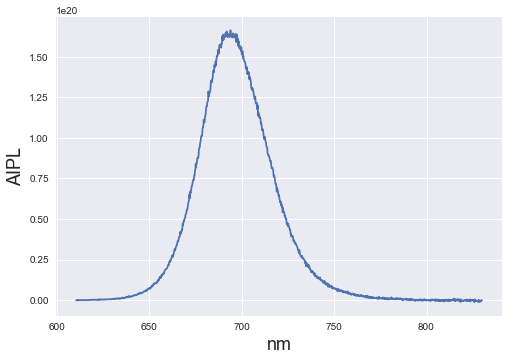

In [164]:
plt.style.use('seaborn')
plt.plot(lam,Ipl)
plt.xlabel('nm', fontsize=18)
plt.ylabel('AIPL',fontsize=18)
#plt.title('Operating Battery Santa Maria 2016',fontsize=18)
#plt.legend(('20% <-> 60%','40% <-> 80%','60% <-> 100%'),fontsize=14)

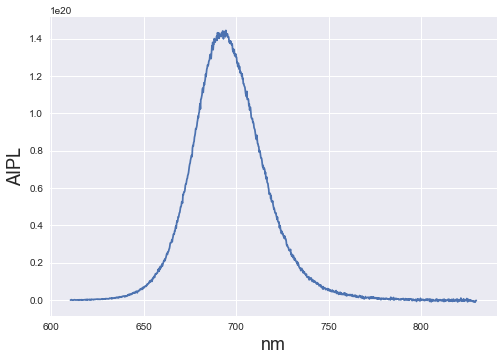

In [170]:
df = pd.read_table('../../data/PLdata/example_spectra/dark.txt',header=None)
dark = df.values
df = pd.read_table('../../data/PLdata/example_spectra/2017_8-25 HPB XY.txt',header=None)
data = df.values
AIPL = PLtools.aipl(data,dark,'500nm')

plt.style.use('seaborn')
plt.plot(AIPL[0,:],AIPL[1,:])
plt.xlabel('nm', fontsize=18)
plt.ylabel('AIPL',fontsize=18)

In [192]:
#def plqy_ext(aipl_data,laser_power):
laser_power = 37*1e-9
    DiodeReadings_1sun = laser_power
    DiodeResponse532= 0.2741
    Area785ImageJ = pi*(6.01e-6)**2
    Ep532 = 2.3305 #E per photon @532

    #Load data from Mathmatica calcs to determine SQ limits @ 300 K and 350 K for various
    #Egs
    Egs = np.loadtxt('../../data/PLdata/vocmax_data/Egs.txt')
    VocSQs300 = np.loadtxt('../../data/PLdata/vocmax_data/VocMaxs.txt') # 300 K
    Jphs = np.loadtxt('../../data/PLdata/vocmax_data/Jphs.txt') #300 K
    VocSQs350 = np.loadtxt('../../data/PLdata/vocmax_data/VocMaxs2.txt') # 350 K
    VocSQs300_fn = interp1d(Egs, VocSQs300, kind='cubic')
    VocSQs350_fn = interp1d(Egs, VocSQs350, kind='cubic')
    Jphs_fn = interp1d(Egs, Jphs, kind='cubic')


    DiodeReading = DiodeReadings_1sun
    P532 = DiodeReading/(DiodeResponse532*Area785ImageJ*10) #W/m^2
    Jp532 = DiodeReading*0.925/(DiodeResponse532*Area785ImageJ*1.60218e-19*Ep532*2)

    if data.shape[1] == 2: #single spectrum
        lam = aipl_data[:,0]
        E = heV*c/(lam*1e-9)
        Ipl = aipl_data[:,1] 
        maxI = np.max(Ipl)
        maxI_idx = np.argmax(Ipl)
        peak_pos = E[maxI_idx]
        HHMax_idx = np.argmin(np.absolute(maxI/2-Ipl[:maxI_idx]))
        LHMax_idx = np.argmin(np.absolute(maxI/2-Ipl[maxI_idx:]))
        LHMax_idx = LHMax_idx+maxI_idx-1
        FWHM = E[HHMax_idx]-E[LHMax_idx]
        VocSQ300 = VocSQs300_fn(E[maxI_idx])
        VocSQ350 = VocSQs350_fn(E[maxI_idx])    
        JphSQ = Jphs_fn(E[maxI_idx])
        NSuns = Jp532*q/JphSQ;
        VocMax300 = VocSQ300 + kb*300/q*np.log(Jp532*q/JphSQ)
        VocMax350 = VocSQ350 + kb*350/q*np.log(Jp532*q/JphSQ)
        TotalPL = np.mean(-E[1:-1]+E[0:-2])/2*(Ipl[0]+Ipl[-1]+2*np.sum(Ipl[1:-2]))
        TotalPL_Eg = np.mean(-E[1:maxI_idx]+E[0:maxI_idx-1])/2*(Ipl[0]+Ipl[maxI_idx]+2*np.sum(Ipl[1:maxI_idx-1]))
        PLQY = TotalPL/Jp532
        dmu_PLQY = VocMax350-kbeV*350*np.log(1/PLQY)
        chi_PLQY = dmu_PLQY/VocMax300 
        chi_PLQY_Eg = (VocMax350-kbeV*350*np.log(1/(TotalPL_Eg/Jp532)))/VocMax300
        PLQY_Eg = TotalPL_Eg/Jp532
        dmu_PLQY_Eg = VocMax350-kbeV*350*np.log(1/(TotalPL_Eg/Jp532))
        mean_Ipl = np.sum(Ipl_raw2*E)/np.sum(Ipl_raw2)
    else: #maps
        k = 0
        while np.isnan(aipl_data[0,k]):
            k = k + 1
        lam = aipl_data[0,k:]
        E = heV*c/(lam*1e-9)
        mean_Ipl = np.zeros(aipl_data.shape[0])
        peak_pos = np.zeros(aipl_data.shape[0])
        FWHM = np.zeros(aipl_data.shape[0])
        PLQY = np.zeros(aipl_data.shape[0])
        dmu_PLQY = np.zeros(aipl_data.shape[0])
        chi_PLQY = np.zeros(aipl_data.shape[0])
        dmu_PLQY_Eg = np.zeros(aipl_data.shape[0])
        chi_PLQY_Eg = np.zeros(aipl_data.shape[0])
        for ii in range(1,aipl_data.shape[0]):
            Ipl = aipl_data[ii,k:]
            maxI = np.max(Ipl)
            maxI_idx = np.argmax(Ipl)
            peak_pos[ii-1] = E[maxI_idx]
            HHMax_idx = np.argmin(np.absolute(maxI/2-Ipl[:maxI_idx]))
            LHMax_idx = np.argmin(np.absolute(maxI/2-Ipl[maxI_idx:]))
            LHMax_idx = LHMax_idx+maxI_idx-1
            FWHM[ii-1] = E[HHMax_idx]-E[LHMax_idx]
            VocSQ300 = VocSQs300_fn(E[maxI_idx])
            VocSQ350 = VocSQs350_fn(E[maxI_idx])    
            JphSQ = Jphs_fn(E[maxI_idx])
            NSuns = Jp532*q/JphSQ;
            VocMax300 = VocSQ300 + kb*300/q*np.log(Jp532*q/JphSQ)
            VocMax350 = VocSQ350 + kb*350/q*np.log(Jp532*q/JphSQ)
            TotalPL = np.mean(-E[1:-1]+E[0:-2])/2*(Ipl[0]+Ipl[-1]+2*np.sum(Ipl[1:-2]))
            TotalPL_Eg = np.mean(-E[1:maxI_idx]+E[0:maxI_idx-1])/2*(Ipl[0]+Ipl[maxI_idx]+2*np.sum(Ipl[1:maxI_idx-1]))
            PLQY[ii-1] = TotalPL/Jp532
            dmu_PLQY[ii-1] = VocMax350-kbeV*350*np.log(1/PLQY[ii-1])
            chi_PLQY[ii-1] = dmu_PLQY[ii-1]/VocMax300 
            chi_PLQY_Eg[ii-1] = (VocMax350-kbeV*350*np.log(1/(TotalPL_Eg/Jp532)))/VocMax300
            PLQY_Eg = TotalPL_Eg/Jp532
            dmu_PLQY_Eg[ii-1] = VocMax350-kbeV*350*np.log(1/(TotalPL_Eg/Jp532))
            mean_Ipl[ii-1] = np.sum(Ipl_raw2*E)/np.sum(Ipl_raw2)




In [194]:
chi_PLQY

array([ 0.87429466,  0.87644725,  0.87752594,  0.87666765,  0.87229858,
        0.8723031 ,  0.88902324,  0.88925031,  0.88620253,  0.8882902 ,
        0.88530709,  0.88970894,  0.88984929,  0.88988495,  0.89102346,
        0.88967219,  0.88922163,  0.89133628,  0.89270084,  0.89091037,
        0.88807132,  0.88642947,  0.88985154,  0.89039998,  0.89138348,
        0.89152397,  0.88948147,  0.89009557,  0.88908025,  0.89038554,
        0.890557  ,  0.88838434,  0.88608478,  0.89126144,  0.89156321,
        0.88973671,  0.89073192,  0.8902223 ,  0.89035462,  0.89039894,
        0.89037027,  0.88911145,  0.88781704,  0.88647727,  0.89089143,
        0.89233799,  0.89105597,  0.89122181,  0.89047501,  0.88888993,
        0.88798803,  0.88745224,  0.89019499,  0.88817261,  0.88720318,
        0.89035494,  0.89265819,  0.88598573,  0.89108295,  0.88966905,
        0.88806329,  0.87293828,  0.88584398,  0.89038416,  0.88907669,
        0.88888181,  0.89098051,  0.89114344,  0.89155557,  0.89

6